In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def detect_and_display_circles_hand(image_path, display=False):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to the image
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    edges = cv2.Canny(blurred, 15, 60, apertureSize=3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=90, minLineLength=1, maxLineGap=80)
    mask = np.ones_like(edges) * 255
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(mask, (x1, y1), (x2, y2), 0, 5)

    edges = cv2.bitwise_and(edges, mask)
    mask_watch = np.ones_like(edges) * 255
    # Mask for the watch
    cv2.rectangle(mask_watch, (0, 850), (1500, 1000), 0, -1)
    edges = cv2.bitwise_and(edges, mask_watch)

    # Apply Hough Circle Transform on the masked image
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=150, param2=22, minRadius=50, maxRadius=100)

    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles in ' + os.path.basename(image_path))
        plt.axis('off')
        plt.show()

    if circles is not None:
        return [(x, y, r) for (x, y, r) in np.uint16(np.around(circles))[0, :]]
    else:
        return []

def detect_and_display_circles_neutral(image_path, display=False):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(gray, (9, 9), 2)

    # Apply adaptive thresholding and morphological operations
    img_th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel)
    closing = cv2.dilate(closing, kernel, iterations=3)

    # Hough Circle Transform
    circles = cv2.HoughCircles(closing, cv2.HOUGH_GRADIENT, dp=1, minDist=100, 
                               param1=50, param2=10, minRadius=50, maxRadius=120)

    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles in ' + os.path.basename(image_path))
        plt.axis('off')
        plt.show()
    
    if circles is not None:
        return [(x, y, r) for (x, y, r) in np.uint16(np.around(circles))[0, :]]
    else:
        return []

def crop_coins(image, circles):
    cropped_images = []
    for (x, y, r) in circles:
        x, y, r = int(x), int(y), int(r)
        cropped_img = image[y-r:y+r, x-r:x+r]
        cropped_images.append(cropped_img)
    return cropped_images

def detect_and_crop_coins(image_path, image_type, display_cropped=True):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    # Call the appropriate detection function
    if image_type == 'neutral':
        circles = detect_and_display_circles_neutral(image_path, display=False)
    elif image_type == 'hand':
        circles = detect_and_display_circles_hand(image_path, display=False)
    else:
        print("Error: Unknown image type")
        return None

    if not circles:
        print("No circles detected")
        return []

    # Crop the detected coins
    cropped_images = crop_coins(img, circles)

    # Display cropped images if required
    if display_cropped:
        for i, cropped_img in enumerate(cropped_images):
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Cropped Coin {i+1}')
            plt.axis('off')
            plt.show()

    return cropped_images

def process_images_in_directory(directory_path, image_type, display_cropped=True):
    if image_type == 'neutral':
        detect_and_display_circles = detect_and_display_circles_neutral
    elif image_type == 'hand':
        detect_and_display_circles = detect_and_display_circles_hand
    else:
        print("Error: Unknown image type")
        return

    # List all jpg images in the directory
    images = glob.glob(os.path.join(directory_path, '*.JPG'))
    for image_path in images:
        circles = detect_and_display_circles(image_path, display=False)
        if circles:
            print(f"Detected circles in {os.path.basename(image_path)}: {circles}")
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            cropped_images = crop_coins(img, circles)
            if display_cropped:
                for i, cropped_img in enumerate(cropped_images):
                    plt.figure(figsize=(4, 4))
                    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
                    plt.title(f'Cropped Coin {i+1}')
                    plt.axis('off')
                    plt.show()
        else:
            print(f"No circles detected in {os.path.basename(image_path)}")

# Example usage for hand images
# process_images_in_directory('path/to/your/hand/image/directory', 'hand', display_cropped=True)

# Example usage for neutral images
# process_images_in_directory('path/to/your/neutral/image/directory', 'neutral', display_cropped=True)


Detected circles in L0000157.JPG: [(654, 622, 86), (862, 734, 82), (672, 346, 77), (852, 440, 66)]


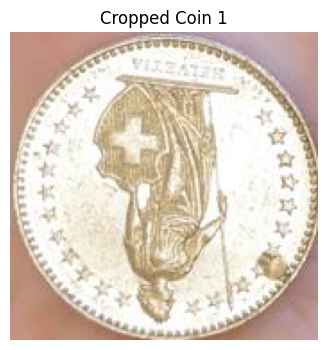

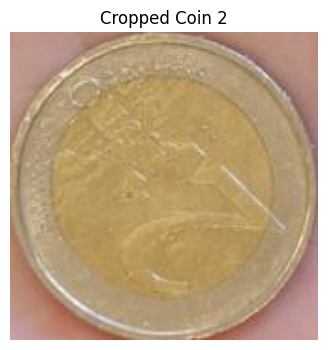

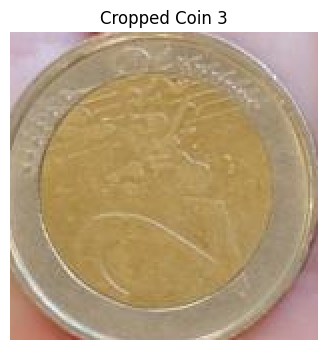

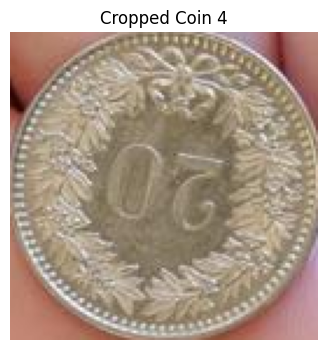

Detected circles in L0000154.JPG: [(528, 548, 77), (654, 798, 81), (720, 612, 97), (484, 718, 54)]


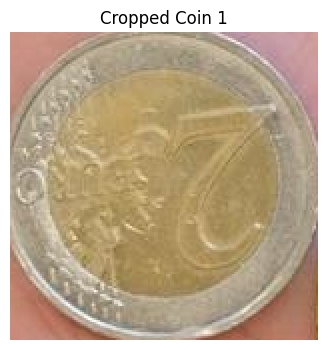

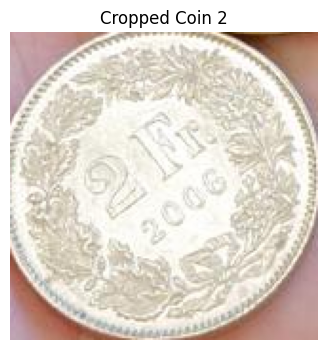

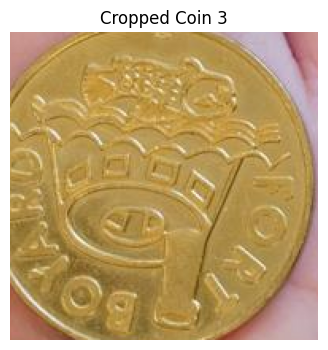

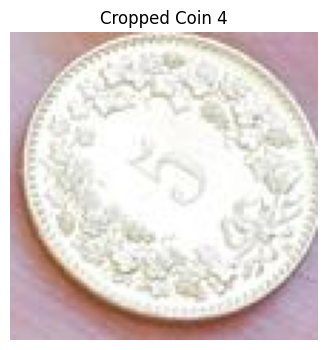

Detected circles in L1010395.JPG: [(874, 670, 74), (988, 784, 50), (794, 486, 66), (580, 444, 55)]


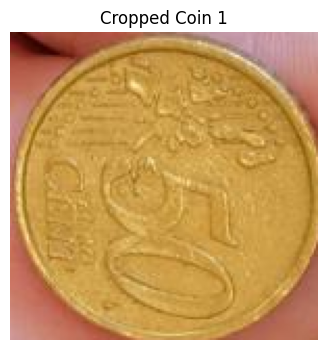

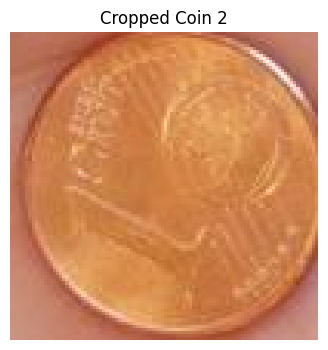

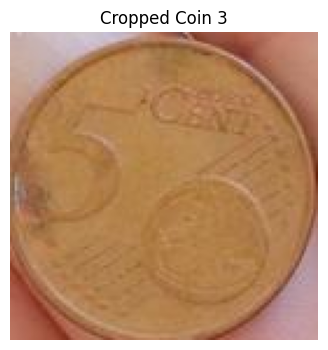

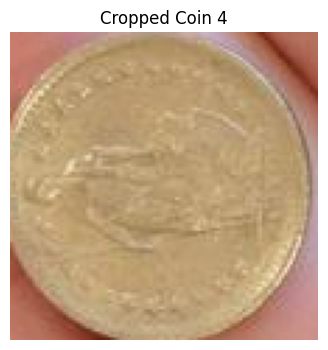

Detected circles in L1010383.JPG: [(802, 800, 59), (548, 426, 66), (698, 686, 52), (742, 314, 66), (788, 498, 53)]


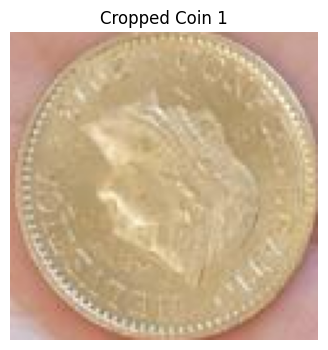

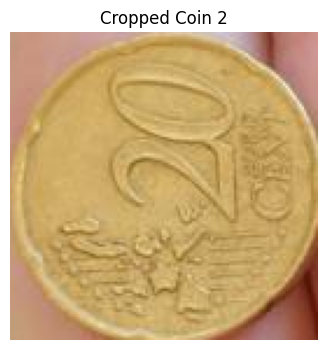

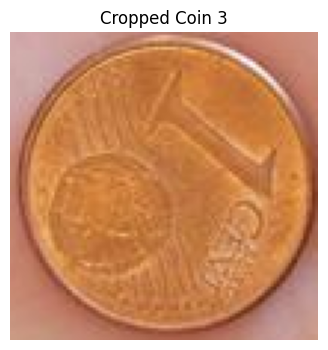

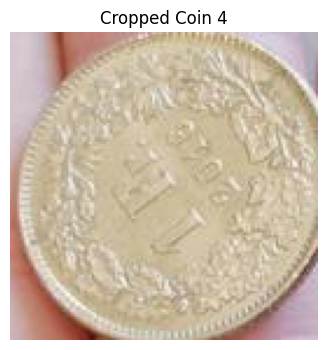

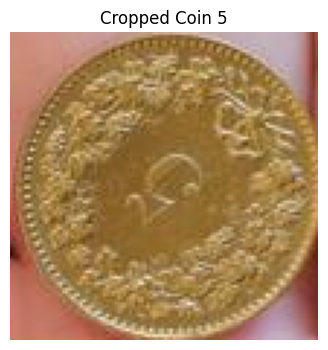

Detected circles in L0000136.JPG: [(804, 588, 82), (936, 512, 69), (730, 420, 68)]


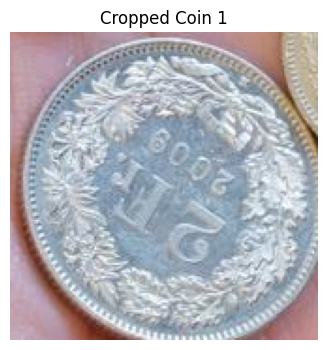

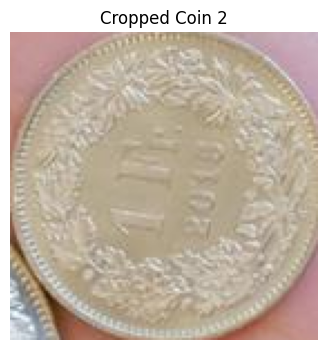

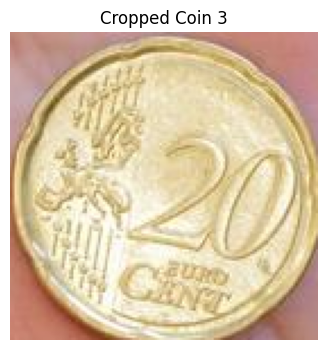

Detected circles in L1010391.JPG: [(838, 658, 85), (720, 540, 80), (862, 496, 70)]


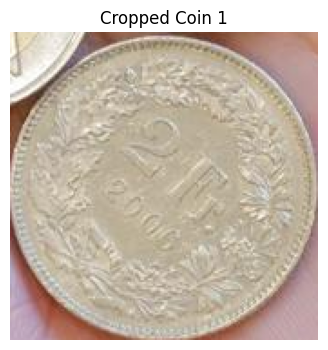

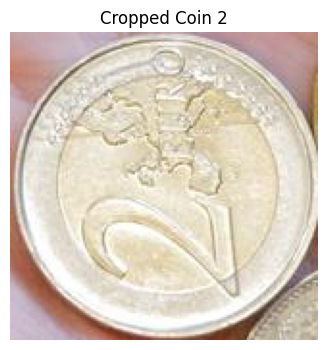

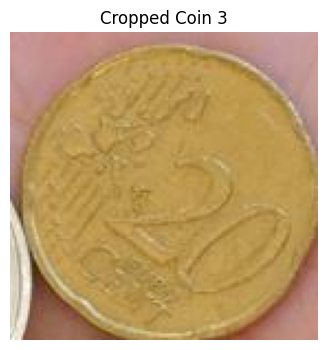

Detected circles in L0000081.JPG: [(712, 500, 97), (872, 436, 68), (688, 306, 81)]


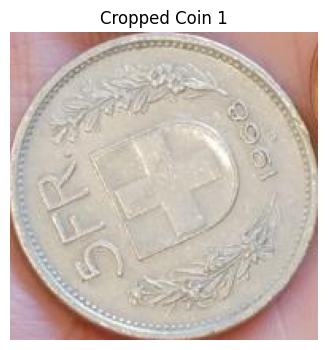

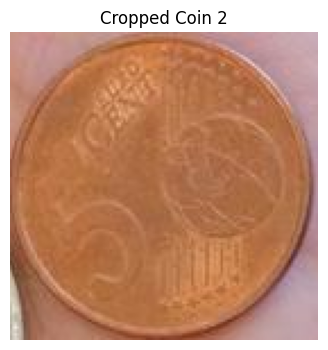

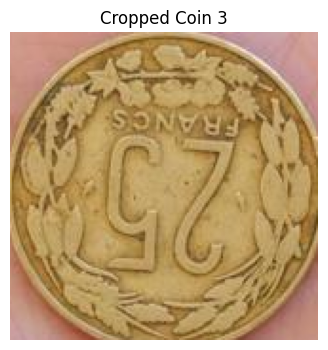

In [23]:
process_images_in_directory('downsampled/train/hand/test', 'hand', display_cropped=True)